<a href="https://colab.research.google.com/github/Mohamed-Ali-Mami/hate-speech-prediction/blob/main/model_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.12.0

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt
import string
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,SpatialDropout1D
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
imb = pd.read_csv("imbalanced_data.csv")
raw = pd.read_csv("raw_data.csv")

In [ ]:
imb

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
imb=imb.drop(columns=["id"])

In [ ]:
raw

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


<Axes: xlabel='label', ylabel='count'>

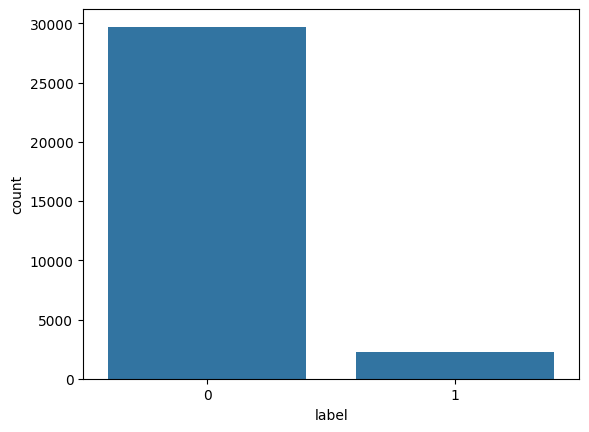

In [ ]:
sns.countplot(data=imb,x="label")

<Axes: xlabel='class', ylabel='count'>

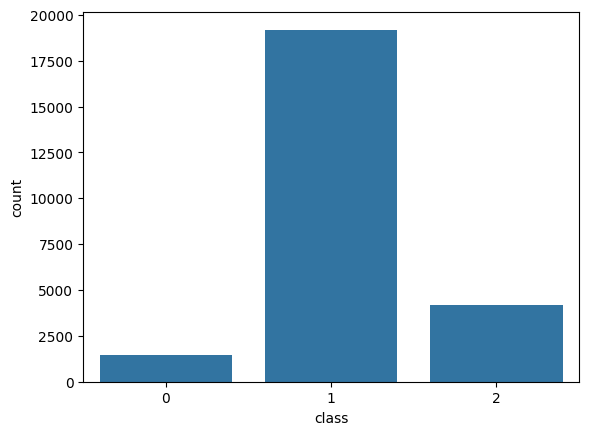

In [ ]:
sns.countplot(data=raw,x="class")

In [ ]:
raw=raw.rename(columns={"class":"label"})
raw["label"]=raw["label"].replace({0:1})

In [ ]:
raw["label"]=raw["label"].replace({2:0})

In [ ]:
df = pd.concat([imb, raw[["tweet", "label"]]], ignore_index=True)


In [ ]:
df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,0,"you've gone and broke the wrong heart baby, an..."
56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,1,youu got wild bitches tellin you lies


<Axes: xlabel='label', ylabel='count'>

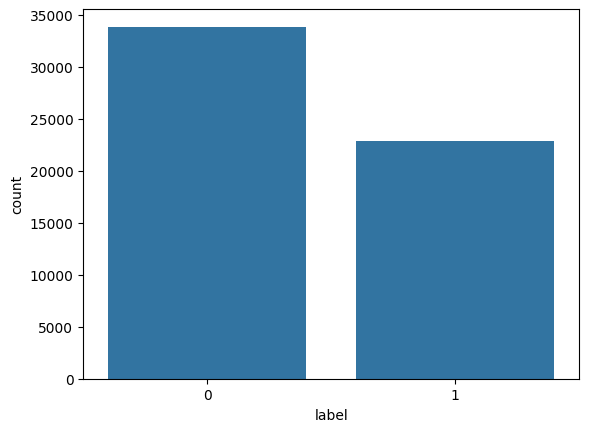

In [ ]:
sns.countplot(data=df,x="label")

In [ ]:
df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,0,"you've gone and broke the wrong heart baby, an..."
56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,1,youu got wild bitches tellin you lies


# pre processing


In [ ]:
import string
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words("english"))

In [ ]:
# Let's apply regex and do cleaning.
def data_cleaning (word):
  word = str(word).lower()
  word = re.sub('\[.*?\]', '', word)
  word = re.sub('https?://\S+|www\.\S+', '',  word)
  word = re.sub('<.*?>+', '', word)
  word = re.sub('[%s]' % re.escape(string.punctuation), '',  word)
  word = re.sub('\n', '', word)
  word = re.sub('\w*\d\w*', '',  word)
  word = re.sub(r'[^\x00-\x7F]+', '', word)
  word = [word for word in word.split(' ') if word not in stopword]
  word=" ".join(word)
  word = [stemmer.stem (word) for word in word.split(' ')]
  word=" ".join(word)
  return word

In [ ]:
print(df.loc[3])

label                                                    0
tweet    #model   i love u take with u all the time in ...
Name: 3, dtype: object


In [ ]:
df["tweet"]=df["tweet"].apply(data_cleaning)
df

,label,tweet
0,0,user father dysfunct selfish drag kid dysfunc...
1,0,user user thank lyft credit cant use caus dont...
2,0,bihday majesti
3,0,model love u take u time ur
4,0,factsguid societi motiv
...,...,...
56740,1,yous muthafin lie coreyemanuel right tl tras...
56741,0,youv gone broke wrong heart babi drove redneck...
56742,1,young buck wanna eat dat nigguh like aint fuck...
56743,1,youu got wild bitch tellin lie


In [ ]:
print(df.loc[3])

label                                   0
tweet    model   love u take u time ur   
Name: 3, dtype: object


In [ ]:
X = df["tweet"]
y= df["label"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

# feature engineering

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [ ]:
vocabulary_size = 50000
sentence_length = 300
word_dimension = 100

In [ ]:
tokenizer = Tokenizer(num_words=vocabulary_size)

In [ ]:
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, padding="pre",maxlen=sentence_length)

In [ ]:
sequences

[[198, 624, 2375, 66, 59, 4, 90],
 [14904,
  14905,
  237,
  102,
  46,
  207,
  4075,
  14906,
  242,
  67,
  418,
  149,
  4076,
  1136,
  1461,
  2376],
 [371, 11, 14907, 14908],
 [2099, 121, 16, 269, 121, 2, 405, 8, 38, 269],
 [10, 146, 424],
 [14909, 14910, 494, 8, 16, 4949],
 [755, 14911, 20, 1, 1, 1],
 [2672,
  274,
  2272,
  874,
  387,
  1461,
  664,
  6355,
  170,
  1,
  905,
  9676,
  7547,
  238,
  523],
 [7, 2, 44, 134, 1875, 134, 63, 120, 17, 293],
 [146, 14, 152, 152, 305, 76],
 [3093, 1, 745, 600],
 [55, 416, 33, 66, 147, 7548, 26, 1022, 127, 668, 100, 26],
 [7549, 7550, 495, 495, 226, 27],
 [593, 215, 24, 1253, 66, 1254, 16, 271, 586, 2],
 [14912, 167, 281, 14913],
 [5, 1089, 669, 1336, 4465, 1337, 524, 169, 67, 4, 169, 615, 50],
 [6356, 29, 283, 377, 50, 108],
 [10, 1825, 86, 4077, 211, 5535, 1940, 262],
 [1, 450, 1, 31, 1, 152, 1620, 75, 379, 670, 275, 51, 2673],
 [3, 7551, 10, 530, 10, 58, 13, 2, 7, 2377, 424],
 [774, 2674, 14914, 2675],
 [10, 525, 23, 432, 1284, 36

In [ ]:
sequences_matrix

array([[    0,     0,     0, ...,    59,     4,    90],
       [    0,     0,     0, ...,  1136,  1461,  2376],
       [    0,     0,     0, ...,    11, 14907, 14908],
       ...,
       [    0,     0,     0, ...,   112,    75,  1393],
       [    0,     0,     0, ...,   875, 12204,   684],
       [    0,     0,     0, ...,   351,   329,     2]], dtype=int32)

# creating the model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,SpatialDropout1D
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary_size, word_dimension, input_length=sentence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense (1, activation='sigmoid'))
model.build(input_shape=(None, 300))  # batch_size=None, sequence_length=300
model.compile(loss='binary_crossentropy', optimizer= RMSprop(),metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 300, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,080,501 (19.38 MB)

 Trainable params: 5,080,501 (19.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(sequences_matrix,y_train, batch_size=128, epochs = 1, validation_split=0.2)

284/284 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.7996 - loss: 0.4342 - val_accuracy: 0.9412 - val_loss: 0.1694


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences,maxlen=sentence_length)

In [ ]:
y_pred = model.predict(padded_test_sequences)
y_pred = np.where(y_pred > 0.5 , 1.0, 0.0)

355/355 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step


In [ ]:
accuracy_score(y_pred,y_test)

0.9320644990748084

# model save and predict

In [ ]:
#save the tokenizer and the model
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

import keras
model.save("model.keras")

In [ ]:
loaded_model = keras.models.load_model("model.keras")
with open('tokenizer.pickle', 'rb') as handle:
  loaded_tokenizer=pickle.load(handle)

In [ ]:
def predict(sentence):
    cleaned_text = data_cleaning(sentence)
    text_sequence = loaded_tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(text_sequence, maxlen=sentence_length)
    prediction = loaded_model.predict(padded_sequence)
    prob = prediction[0][0]
    print("Raw prediction score:", prob)
    if prob > 0.5:
        print("hate and abusive")
    else:
        print("no hate")


In [ ]:
predict("I'm so happy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Raw prediction score: 0.033475704
no hate
